# HyperbolicTSNE

This notebook illustrates the usage of the HyperbolicTSNE library. Specifically, we load a subset of the MNIST dataset and embed it in hyperbolic space using the accelerated version of hyperbolic tsne. Finally, we save the embedding result as an image.

## Setup

First, we import the packages we will use and set important paths. Note that `hyperbolicTSNE.util` and `hyperbolicTSNE.visualization` contain useful functions for reading, processing and exporting embeddings. This requires that hyperbolicTSNE has been set up as detailed in the main readme of the repository. 

In [21]:
import os
import traceback
import numpy as np
#from cuda import cuda, nvrtc

import gpu

from hyperbolicTSNE.util import find_last_embedding
from hyperbolicTSNE.visualization import plot_poincare, animate
from hyperbolicTSNE import load_data, Datasets, SequentialOptimizer, initialization, HyperbolicTSNE


# =============== GPU TESTING PyCUDA ===============
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

# CUDA kernel written as a string
cuda_kernel = """
__global__ void add(int *a, int *b, int *c) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    c[idx] = a[idx] + b[idx];
}
"""

cuda.init()

# Compile the CUDA kernel
mod = SourceModule(cuda_kernel)

# Get the kernel function
add_cuda = mod.get_function("add")

# Example usage
import numpy as np
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.zeros_like(a)

# Allocate GPU memory
a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)
c_gpu = cuda.mem_alloc(c.nbytes)

# Transfer data to GPU memory
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

# Launch the CUDA kernel
print("c0: ", c)
add_cuda(a_gpu, b_gpu, c_gpu, block=(3, 1, 1), grid=(1, 1))
print("c1: ", c)
# Transfer results back to CPU
cuda.memcpy_dtoh(c, c_gpu)

print("c: ", c)  # Output: [5 7 9]















c0:  [0 0 0]
c1:  [0 0 0]
c:  [5 7 9]


In [12]:



# ============ GPU TESTING ============


def ASSERT_DRV(err):
    if isinstance(err, cuda.CUresult):
        if err != cuda.CUresult.CUDA_SUCCESS:
            raise RuntimeError("Cuda Error: {}".format(err))
    elif isinstance(err, nvrtc.nvrtcResult):
        if err != nvrtc.nvrtcResult.NVRTC_SUCCESS:
            raise RuntimeError("Nvrtc Error: {}".format(err))
    else:
        raise RuntimeError("Unknown error type: {}".format(err))
    


saxpy = """\
extern "C" __global__
void saxpy(float a, float *x, float *y, float *out, size_t n)
{
 size_t tid = blockIdx.x * blockDim.x + threadIdx.x;
 if (tid < n) {
   out[tid] = a * x[tid] + y[tid];
 }
}
"""
# Create program
err, prog = nvrtc.nvrtcCreateProgram(str.encode(saxpy), b"saxpy.cu", 0, [], [])

# Compile program
opts = [b"--fmad=false", b"--gpu-architecture=compute_75"]
err, = nvrtc.nvrtcCompileProgram(prog, 2, opts)

# Get PTX from compilation
err, ptxSize = nvrtc.nvrtcGetPTXSize(prog)
ptx = b" " * ptxSize
err, = nvrtc.nvrtcGetPTX(prog, ptx)



# Initialize CUDA Driver API
err, = cuda.cuInit(0)

# Retrieve handle for device 0
err, cuDevice = cuda.cuDeviceGet(0)

# Create context
err, context = cuda.cuCtxCreate(0, cuDevice)



# Load PTX as module data and retrieve function
ptx = np.char.array(ptx)
# Note: Incompatible --gpu-architecture would be detected here
err, module = cuda.cuModuleLoadData(ptx.ctypes.data)
ASSERT_DRV(err)
err, kernel = cuda.cuModuleGetFunction(module, b"saxpy")
ASSERT_DRV(err)

NUM_THREADS = 16  # Threads per block
NUM_BLOCKS = 16  # Blocks per grid

a = np.array([2.0], dtype=np.float32)
n = np.array(NUM_THREADS * NUM_BLOCKS, dtype=np.uint32)
bufferSize = n * a.itemsize

hX = np.random.rand(n).astype(dtype=np.float32)
hY = np.random.rand(n).astype(dtype=np.float32)
hOut = np.zeros(n).astype(dtype=np.float32)


err, dXclass = cuda.cuMemAlloc(bufferSize)
err, dYclass = cuda.cuMemAlloc(bufferSize)
err, dOutclass = cuda.cuMemAlloc(bufferSize)

err, stream = cuda.cuStreamCreate(0)

err, = cuda.cuMemcpyHtoDAsync(
   dXclass, hX.ctypes.data, bufferSize, stream
)
err, = cuda.cuMemcpyHtoDAsync(
   dYclass, hY.ctypes.data, bufferSize, stream
)



# The following code example is not intuitive 
# Subject to change in a future release
dX = np.array([int(dXclass)], dtype=np.uint64)
dY = np.array([int(dYclass)], dtype=np.uint64)
dOut = np.array([int(dOutclass)], dtype=np.uint64)

args = [a, dX, dY, dOut, n]
args = np.array([arg.ctypes.data for arg in args], dtype=np.uint64)



err, = cuda.cuLaunchKernel(
   kernel,
   NUM_BLOCKS,  # grid x dim
   1,  # grid y dim
   1,  # grid z dim
   NUM_THREADS,  # block x dim
   1,  # block y dim
   1,  # block z dim
   0,  # dynamic shared memory
   stream,  # stream
   args.ctypes.data,  # kernel arguments
   0,  # extra (ignore)
)

err, = cuda.cuMemcpyDtoHAsync(
   hOut.ctypes.data, dOutclass, bufferSize, stream
)
err, = cuda.cuStreamSynchronize(stream)



# Assert values are same after running kernel
hZ = a * hX + hY
if not np.allclose(hOut, hZ):
   raise ValueError("Error outside tolerance for host-device vectors")





err, = cuda.cuStreamDestroy(stream)
err, = cuda.cuMemFree(dXclass)
err, = cuda.cuMemFree(dYclass)
err, = cuda.cuMemFree(dOutclass)
err, = cuda.cuModuleUnload(module)
err, = cuda.cuCtxDestroy(context)




#gpu.gpu_reset()

#gpu.gpu_init()

AttributeError: module 'pycuda.driver' has no attribute 'cuInit'

We assume that there is a top-level folder `datasets` that holds the MNIST data set. Refer to the main readme of the repository for where to find the data sets used in this repository.

In [2]:
data_home = "datasets"
log_path = "temp/poincare/"  # path for saving embedding snapshots

## Configure

HyperbolicTSNE follows a similar API to other t-SNE libraries like OpenTSNE and sklearn. The configuration process consists of loading the data to embed and defining the settings of the embedder. We create a dict with parameters manually to demonstrate all the customization options. Nevertheless, `hyperbolicTSNE.hyperbolicTSNE` provides parameter templates to start with.

In [3]:
only_animate = False
seed = 42
dataset = Datasets.PLANARIA  # the Datasets handler provides access to several data sets used throughout the repository
num_points = 1000  # we use a subset for demonstration purposes, full MNIST has N=70000
perp = 30  # we use a perplexity of 30 in this example

dataX, dataLabels, D, V, _ = load_data(
    dataset, 
    data_home=data_home, 
    random_state=seed, 
    to_return="X_labels_D_V",
    hd_params={"perplexity": perp}, 
    sample=num_points, 
    knn_method="hnswlib"  # we use an approximation of high-dimensional neighbors to speed up computations
)

In [4]:
exaggeration_factor = 12  # Just like regular t-SNE, we use early exaggeration with a factor of 12
learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)  # We adjust the learning rate to the hyperbolic setting
ex_iterations = 250  # The embedder is to execute 250 iterations of early exaggeration, ...
main_iterations = 750  # ... followed by 750 iterations of non-exaggerated gradient descent.

opt_config = dict(
    learning_rate_ex=learning_rate,  # learning rate during exaggeration
    learning_rate_main=learning_rate,  # learning rate main optimization 
    exaggeration=exaggeration_factor, 
    exaggeration_its=ex_iterations, 
    gradientDescent_its=main_iterations, 
    vanilla=False,  # if vanilla is set to true, regular gradient descent without any modifications is performed; for  vanilla set to false, the optimization makes use of momentum and gains
    momentum_ex=0.5,  # Set momentum during early exaggeration to 0.5
    momentum=0.8,  # Set momentum during non-exaggerated gradient descent to 0.8
    exact=True,  # To use the quad tree for acceleration (like Barnes-Hut in the Euclidean setting) or to evaluate the gradient exactly
    area_split=False,  # To build or not build the polar quad tree based on equal area splitting or - alternatively - on equal length splitting
    n_iter_check=10,  # Needed for early stopping criterion
    size_tol=0.999  # Size of the embedding to be used as early stopping criterion
)

opt_params = SequentialOptimizer.sequence_poincare(**opt_config)

# Start: configure logging
logging_dict = {
    "log_path": log_path
}
opt_params["logging_dict"] = logging_dict

log_path = opt_params["logging_dict"]["log_path"]
# Delete old log path
if os.path.exists(log_path) and not only_animate:
    import shutil
    shutil.rmtree(log_path)
# End: logging

print(f"config: {opt_config}")

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'learning_rate_ex': 0.08333333333333333, 'learning_rate_main': 0.08333333333333333, 'exaggeration': 12, 'exaggeration_its': 250, 'gradientDescent_its': 750, 'vanilla': False, 'momentum_ex': 0.5, 'momentum': 0.8, 'exact': True, 'area_split': False, 'n_iter_check': 10, 'size_tol': 0.999}


## Run HyperbolicTSNE

Embedding the high dimensional data consists of three steps:
- Initializating the embedding
- Initializing the embedder 
- Embedding the data

The following three cells demonstrate this process. Note that use set metric to "precomputed" because we pass the distance matrix to the `fit` method.

In [5]:
# Compute an initial embedding of the data via PCA
X_embedded = initialization(
    n_samples=dataX.shape[0],
    n_components=2,
    X=dataX,
    random_state=seed,
    method="pca"
)

In [6]:
# Initialize the embedder
htsne = HyperbolicTSNE(
    init=X_embedded, 
    n_components=2, 
    metric="precomputed", 
    verbose=True, 
    opt_method=SequentialOptimizer, 
    opt_params=opt_params
)

In [7]:
# Compute the embedding
# 10000 data points exact: ~12 minutes for first part
gpu.gpu_reset()
try:
    hyperbolicEmbedding = htsne.fit_transform((D, V))
except ValueError:
    print("Error!")
    hyperbolicEmbedding = find_last_embedding(log_path)
    traceback.print_exc()

[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: True
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration
performing gradient descent!


Gradient Descent:   0%|          | 0/250 [00:00<?, ?it/s]

pos shape:  (1000, 2)
pos min:  -0.00030045650782994926
pos max:  0.0006106068613007665
========== RUNNING GPU CODE ==========
code:
__global__ void saxpy(float a, float *x, float *y, float *out, size_t n)
{
    size_t tid = blockIdx.x * blockDim.x + threadIdx.x;
    if (tid < n) {
        out[tid] = a * x[tid] + y[tid];
    }
}
code 2:
    extern "C" __global__
    void saxpy(float a, float *x, float *y, float *out, size_t n)
    {
        size_t tid = blockIdx.x * blockDim.x + threadIdx.x;
        if (tid < n) {
            out[tid] = a * x[tid] + y[tid];
        }
    }
    


Gradient Descent:   0%|          | 0/250 [00:00<?, ?it/s]


RuntimeError: Cuda Error (218): 1

## Exporting and visualization

After running the embedding process, the embeddings arrays are saved to the `log_path`. We can use this information to visualize the embeddings using utility functions defined in `hyperbolicTSNE.visualization` as shown below.

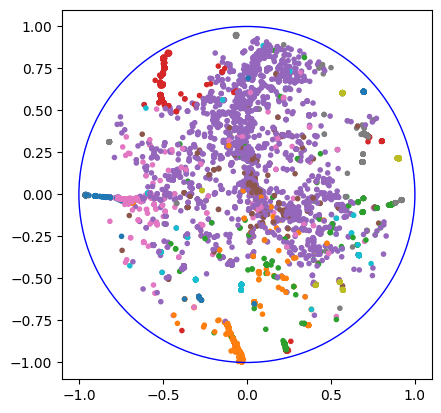

In [60]:
# Create a rendering of the embedding and save it to a file
if not os.path.exists("results"):
    os.mkdir("results")
fig = plot_poincare(hyperbolicEmbedding, dataLabels)
fig.savefig(f"results/{dataset.name}.png")

In [53]:
# This renders a GIF animation of the embedding process. If FFMPEG is installed, the command also supports .mp4 as file ending 
animate(logging_dict, dataLabels, f"results/{dataset.name}_ani.gif", fast=True, plot_ee=True)

Animation being saved to: results/PLANARIA_ani.gif


Animating:   0%|          | 0/55 [00:00<?, ?it/s]c:\Git\hyperbolic-tsne\hyperbolicTSNE\visualization.py:320: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=55.
  anim = FuncAnimation(fig, update, frames=len(scatter_data), interval=50, blit=True, save_count=50)
Animating: : 58it [00:08,  7.10it/s]                      
